In [1]:
from scipy import stats
from sklearn.datasets import fetch_openml, load_iris
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chapter 5

## 1. What is the fundamental idea behind Support Vector Machines? 
A SVM seeks to segment two independent groups instances through inserting a vector between these two groups of instances with as wide as margin about the line as possible, while simultaneously minimizing the number of instances that overlap this span. This can be achieved through either not allowign any overlap (hard margin) or minimizing the number of overlap (soft margin). Or in the case of regression, the process seeks to keep as many instances between the margins of the vector. Through differing kernels, this vector can be nonlinear and highly complex.  

## 2. What is a support vector?
A support vector is a (hyper) point which is an instance that lies within the margin about the segmenting line or on the boundary. These points fully support the decision boundary and only these points. As such it is these points that are used for the prediction process. Hard magin will only have support vectors on the boundary, whereas soft margin will allow support vectors within the margin.  

## 3. Why is it important to scale the inputs when using SVMs? 
SVMs are very sensitive to differing scales of values and will affect the process of creating the support vectors. This is due to the SVM neglecting small features in the process of maximizing the margins about the decision boundary. 

## 4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability? 
A SVM classifier can produce a score that is based upon the kernel that is measure of "distance" between the point and the decision boundary but it cannot produce a probability directly. 

## 5. Should you use the primal or dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features? 
A kernalized SVM must use the dual form. For a linear SVM that can use either the primal or the dual form, and the complexity for the dual form scales like $O(m^2 + n)$ to $O(m^3 + n)$. So it is polynomial time in the number of instances but linear in the number of features. Whereas the primal form scales linearly in both. 

## 6. Say you've trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease $\gamma$? What about C? 
Increasing $/gamma$ will increase the complexity of the model, thereby fitting better. Additionally one can increase $C$ to adjust Hinge loss as well to add complexity.

## 7. How should you set the QP parameters (**H**, **f**, **A**, and **b**) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver? 
meh





## 10. Train SVM on housing data set


## 8. Train a `LinearSVC` classifier on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce rougly the same model. 

In [53]:
iris = load_iris()
X = iris["data"][:, (2, 3)] # petal length, width
y = (iris["target"] == 2).astype(np.float64) # virginica

In [54]:
strat_split = StratifiedShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_idx, test_idx = next(strat_split.split(X, y))
X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [80]:
# LinearSVC
lin_svm = Pipeline([("scaler", StandardScaler()),
                    ("linear_svc", LinearSVC(loss="hinge", max_iter=20000))
                   ])

pgrid = [{"linear_svc__C": [1, 10, 100, 1000], 
         "linear_svc__dual": [True]}, 
         {"linear_svc__C": [1, 10, 100, 1000], 
          "linear_svc__dual": [False],
          "linear_svc__penalty": ["l1"],
          "linear_svc__loss": ["squared_hinge"]
         }]

strat_fold = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
grid_cv = GridSearchCV(lin_svm, pgrid, cv=strat_fold)

In [81]:
grid_cv.fit(X_train, y_train);

In [82]:
y_hat = grid_cv.predict(X_test)

In [83]:
f1_score(y_test, y_hat)

0.9473684210526316

In [99]:
lin_coefs = grid_cv.best_estimator_.named_steps['linear_svc'].coef_
lin_int = grid_cv.best_estimator_.named_steps['linear_svc'].intercept_
print(f'coefs: {lin_coefs}, int: {lin_int}')

coefs: [[1.43277667 2.06540262]], int: [-2.12488123]


In [145]:
lin_m = -lin_coefs[0, 0]/lin_coefs[0, 1]
lin_int = -lin_int[0]/lin_coefs[0, 1]

In [59]:
# SVC
svc = Pipeline([("scaler", StandardScaler()),
                ("svc", SVC(max_iter=20000, kernel="linear"))
                   ])

pgrid = {"svc__C": [1, 10, 100, 1000]
         }

strat_fold = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
svc_grid_cv = GridSearchCV(svc, pgrid, cv=strat_fold)

In [60]:
svc_grid_cv.fit(X_train, y_train);

In [61]:
y_svc_hat = svc_grid_cv.predict(X_test)
f1_score(y_test, y_svc_hat)

0.9473684210526316

In [98]:
svc_coefs = svc_grid_cv.best_estimator_.named_steps['svc'].coef_
svc_int = svc_grid_cv.best_estimator_.named_steps['svc'].intercept_
print(f'coefs: {svc_coefs}, int: {svc_int}')

coefs: [[1.8891107  2.44451219]], int: [-2.82657588]


In [142]:
svc_m = -svc_coefs[0, 0]/svc_coefs[0, 1]
svc_int = -svc_int[0]/svc_coefs[0, 1]

In [100]:
# SGD
sgd = Pipeline([("scaler", StandardScaler()),
                ("sgd", SGDClassifier(max_iter=20000))
                   ])

pgrid = {"sgd__alpha": [.0001, .001, .01, .1]
         }

strat_fold = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
sgd_grid_cv = GridSearchCV(sgd, pgrid, cv=strat_fold)

In [101]:
sgd_grid_cv.fit(X_train, y_train);

In [102]:
y_sgd_hat = sgd_grid_cv.predict(X_test)
f1_score(y_test, y_sgd_hat)

0.9473684210526316

In [103]:
sgd_coefs = sgd_grid_cv.best_estimator_.named_steps['sgd'].coef_
sgd_int = sgd_grid_cv.best_estimator_.named_steps['sgd'].intercept_
print(f'coefs: {sgd_coefs}, int: {sgd_int}')

coefs: [[0.87210446 1.12608346]], int: [-1.36855837]


In [117]:
# at decision boundary w0*x0 + w1+x1 + b = 0 -> x1 = -(w0*x0)/w1 -b/w1
sgd_m = -sgd_coefs[0, 0]/sgd_coefs[0, 1]
sgd_int = -sgd_int[0]/sgd_coefs[0, 1]

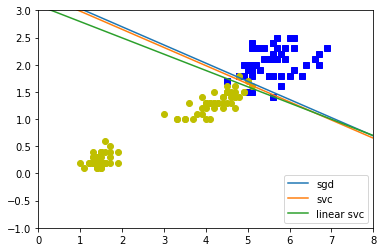

In [150]:
sgd_l = sgd_grid_cv.best_estimator_.named_steps['scaler'].inverse_transform([[-10, -10*sgd_m + sgd_int], [10, 10*sgd_m + sgd_int]])
svc_l = svc_grid_cv.best_estimator_.named_steps['scaler'].inverse_transform([[-10, -10*svc_m + svc_int], [10, 10*svc_m + svc_int]])
lin_l = grid_cv.best_estimator_.named_steps['scaler'].inverse_transform([[-10, -10*lin_m + lin_int], [10, 10*lin_m + lin_int]])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # virginica
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # not virginica
plt.plot(sgd_l[:,0], sgd_l[:,1], label='sgd')
plt.plot(svc_l[:,0], svc_l[:,1], label='svc')
plt.plot(lin_l[:,0], lin_l[:,1], label='linear svc')
plt.legend(loc='lower right')
plt.axis([0, 8, -1, 3]);

## 9. Train an SVM classifier on the MNIST dataset. Since the SVM  classifier are binary classifiers, you will need to use a one-versus-the-rest to classify all 10 digits. 

In [17]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [18]:
# Get Data
X = mnist['data']
y= mnist['target']

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
strat_split = StratifiedShuffleSplit(n_splits=1, train_size=.9, random_state=42)
train_idx, val_idx = next(strat_split.split(X_train, y_train))
training = X_train[train_idx]
train_targ = y_train[train_idx]
val = X_train[val_idx]
val_targ = y_train[val_idx]

In [23]:
svc_pl = Pipeline([("scaler", StandardScaler()),
                ("svc", SVC(decision_function_shape='ovr'))
                   ])

pgrid = [{"svc__C": stats.halfnorm(loc=1, scale=20),
          "svc__kernel": ["rbf", "poly"],
          "svc__degree": [2, 3, 5, 7],
          "svc__gamma": stats.reciprocal(.0001, .01)
         }]

strat_fold = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
svc_cv = RandomizedSearchCV(svc_pl, pgrid, cv=strat_fold, n_iter=10, verbose=2, n_jobs=4)
# svc_cv = GridSearchCV(svc_pl, pgrid, cv=strat_fold)

In [24]:
svc_cv.fit(val, val_targ)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 10.2min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_jobs=4,
                   param_distributions=[{'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8804b42fd0>,
                                         'svc__degree': [2, 3, 5, 7],
                                         'svc__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8804b23da0>,
                                         'svc__kernel': ['rbf', 'poly']}],
                   verbose=2)

In [25]:
svc_cv.best_score_

0.9141666666666666

In [26]:
svc_cv.best_estimator_.fit(training, train_targ)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=29.405650201689127, gamma=0.00011400041507346868))])

In [27]:
y_hat = svc_cv.best_estimator_.predict(X_test)
accuracy_score(y_test, y_hat)

0.9593